# Dynamics of spin in magnetic fields with Qiskit

You have already familiarized yourself with Pennylane, a Python framework for quantum computing.

Today, we will learn about another one, Qiskit; it is developed by IBM and designed for general-purpose quantum computing. While it is particularly useful for building quantum circuits and executing them on IBM real quantum processors, in this exercise, we are going to focus on the spin dynamics.

The documentation can be found here: https://docs.quantum.ibm.com/


### Installation

The latest (as of November 2024) version of Qiskit is 1.2. Before moving to the next step, please make sure that you have NOT installed Qiskit version 0.X some time ago; if in doubt, you can verify this by running
```
pip show qiskit
```
command in the Python environment in the terminal. If you have, please create a new virtual environment to install Qiskit 1.X there.

Then, you can proceed with
```
pip install qiskit[visualization]
```
or, for `zsh` (Z shell),
```
pip install 'qiskit[visualization]'
```
. `visualization` support is required for this exercise.

It is also recommended to install Qiskit Runtime (`pip install qiskit-ibm-runtime`) to run jobs on quantum hardware in the future, but it won't be used in this notebook.

Let's verify the installation went successfully:

In [1]:
import qiskit

qiskit.__version__

'1.2.4'

## Exercise TODO

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

First of all, we will visualize the eigenbases of the Pauli operators, i.e.:
- for $Z$:
$$\left\{ |0 \rangle \equiv | \uparrow \rangle, \quad |1 \rangle \equiv | \downarrow \rangle \right\};$$
- for $X$:
$$\left\{ |+ \rangle  \equiv  \frac{1}{\sqrt{2}} \left( | \uparrow \rangle +  | \downarrow \rangle  \right),\quad
| - \rangle  \equiv  \frac{1}{\sqrt{2}} \left( | \uparrow \rangle -  | \downarrow \rangle  \right)
\right\};$$
- for $Y$:
$$\left\{ | +i  \rangle  \equiv   | \circlearrowleft  \rangle  \equiv  \frac{1}{\sqrt{2}} \left( | \uparrow \rangle + i | \downarrow \rangle  \right),\quad
| -i \rangle  \equiv  \frac{1}{\sqrt{2}} \left( | \uparrow \rangle - i | \downarrow \rangle  \right)
\right\}.$$

**Question**: Below, fill in the coordinates of their representations on the Bloch sphere:

In [3]:
bloch_states = {
    "|0⟩": [0, 0, 1],
    "|1⟩": [0, 0, -1],
    "|+⟩": [1, 0, 0],
    "|-⟩": [-1, 0, 0],
    "|+i⟩": [0, 1, 0],
    "|-i⟩": [0, -1, 0]
}

If you gave correct answers, the image below should agree with one in the lecture:

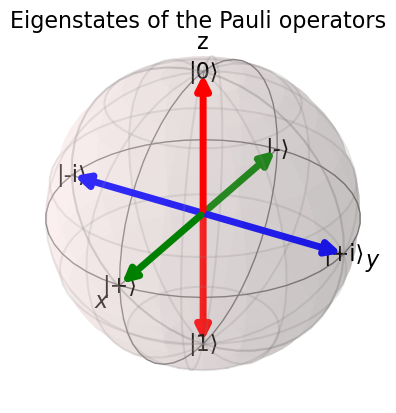

In [4]:
from qiskit.visualization.bloch import Bloch

fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))

B = Bloch(axes=ax, font_size=16)

# The color order here should correspond to the order of adding statevectors to the plot
B.vector_color = ['red', 'red', 'green', 'green', 'blue', 'blue']
B.zlabel = ['z', '']

for key, value in bloch_states.items():
    B.add_vectors([value])
    B.add_annotation(value, key)
    
B.render(title="Eigenstates of the Pauli operators")

## Larmor precession

Now, we are going to illustrate the dynamics of spin under a constant magnetic field $\vec{B} = (0, 0, B_0)$ oriented in the $z$ direction.

First of all, we need to initialize the state of spin. For representing a quantum state vector, we use the class [`qiskit.quantum_info.Statevector`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Statevector).

**Question**: complete the function below s.t., given the parametrization $| \theta, \phi \rangle $ on the Bloch sphere, it returns the correct state representation in $\mathbb{C}^2$.

*Hint*: you can use `1j` to get an imaginary unit $i$ in Python.



In [5]:
from qiskit.quantum_info import Statevector

def angles2statevector(theta, phi):
    data = np.array([np.cos(theta/2), np.exp(phi * 1j) * np.sin(theta/2)])
    return Statevector(data)

The state will be illustrated on the Bloch sphere below. You can vary the parameters $\theta$ and $\phi$ to make sure your formula is correct.

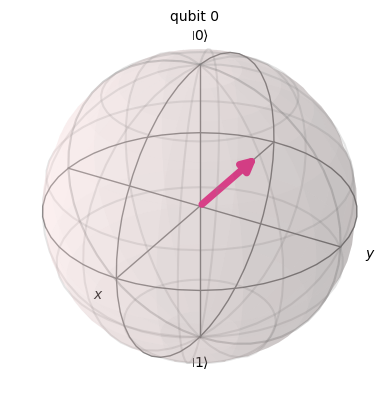

In [6]:
theta = np.pi / 4
phi = np.pi / 3

psi_0 = angles2statevector(theta, phi)
psi_0.draw('bloch')

We will take the state defined above as the initial state of the spin $| \psi_0\rangle$.

We associate the magnitude $B_0$ of the applied magnetic field with the Larmor frequency $\omega_0$ ($B_0 = \gamma \omega_0$). For this setting, in the lecture, we derived the evolution operator
$$
U_t  = \exp \left( i t \frac{\omega_0}{2} \sigma_z \right)
$$

To represent a general matrix operator, we use a class [`qiskit.quantum_info.Operator`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Operator). For Pauli operators, we can use [`qiskit.quantum_info.SparsePauliOp`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp): the instances can be initialized with strings (like we do below), and you can perform algebraic operations on them.

**Question:** complete the function below such that it returns the operator $U_t$.

*Hint:* to compute matrix exponential, you can use [`scipy.linalg.expm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html).

In [7]:
import scipy.linalg
from qiskit.quantum_info import Operator, SparsePauliOp

X, Y, Z = SparsePauliOp('X'), SparsePauliOp('Y'), SparsePauliOp('Z')

def operator_Larmor_precession(omega_0, t):
    return Operator(scipy.linalg.expm(1.j * t * omega_0 * Z / 2))

**Question**: given $\omega_0$, what is the value of $T$, the rotation period?

In [8]:
omega_0 = np.pi / 2
T_period = 2 * np.pi / omega_0

We will evolve state $|\psi_t\rangle = U_t |\psi_0 \rangle$ from $0$ to $T$, i.e. for a single complete turn.

**Question**: Evaluate  $|\psi_t\rangle$ on the given time points from $0$ to $T$.

*Hint:* Use the [`.evolve`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Statevector#evolve) method of the `Statevector` class

In [9]:
n_points = 200
t = np.linspace(0, T_period, n_points)

psi_t = [psi_0.evolve(operator_Larmor_precession(omega_0, t_val)) for t_val in t]

If everything is correct, below you should see the trajectory of the precession; the lighter color corresponds to the later state.

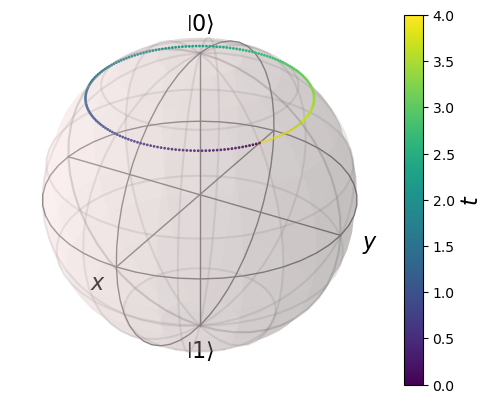

In [10]:
import matplotlib as mpl
from qiskit.visualization.state_visualization import _bloch_multivector_data


def visualize_evolution_bloch(t, psi_t):
    bloch_pts = np.vstack(list(map(_bloch_multivector_data, psi_t))).T

    fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
    norm = mpl.colors.Normalize(t.min(), t.max())
    
    B = Bloch(axes=ax, font_size=16)
    B.point_size = [1]
    cmap = mpl.colormaps['viridis']
    B.point_color = list(map(cmap, (t - t.min()) / (t.max() - t.min())))
    
    B.add_points(bloch_pts, meth='m')
    B.render()
    
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label(label='$t$', size=16)


visualize_evolution_bloch(t, psi_t)

## Rabi oscillations

Next, we will consider the magnetic field that, aside from the constant component oriented along the $z$ axis, has a component rotating in the $x$-$y$ plane as well, i.e.

$$
\vec{B} = (0, 0, B_0) + (B_1 \cos(\omega t), -B_1 \sin(\omega t), 0).
$$

The frequency $\omega_1$ is associated to $B_1$ ($\omega_1 = \gamma B_1$).

From the lectures, we know that the evolution operator (under a rotating reference frame) in this case is:

$$  
\tilde{U}_t = 
 \exp \left\{- i \frac{t }{2}  \left( \delta \sigma_z - \omega_1 \sigma_x \right)  \right\}
, $$

where $\delta = \omega - \omega_0$ is a difference between the rotating field and Larmor frequencies.

**Question:** Complete the function below such that it returns the operator $\tilde{U}_t$.


In [11]:
def operator_Rabi_oscillations(delta, omega_1, t): 
    H = delta * Z - omega_1 * X
    return Operator(scipy.linalg.expm(-1.j * t / 2 * H))

Let's reproduce plots from the lecture. As we learned, if we write evolution operator as 
$$
U_t = \begin{pmatrix}
u_{\uparrow \uparrow} & u_{\uparrow \downarrow} \\
u_{\downarrow \uparrow} & u_{\downarrow \downarrow}
\end{pmatrix},
$$

we can compute state probability transitions as 
$$ P_{| \uparrow \rangle \to |\downarrow \rangle } (t) = 
\left| u_{\uparrow \downarrow} \right|^2, \quad
P_{| \uparrow \rangle \to |\uparrow \rangle } (t) = 
\left| u_{\uparrow \uparrow} \right|^2.
$$
During the computation, dependence on the change of basis disappears, so you can consider elements of  $\tilde{U}_t$ instead of those of $U_t$.

**Question:** What is the period $T$ of $P_{| \uparrow \rangle \to |\downarrow \rangle } (t) $? What is its maximum value?  

In [12]:
delta = np.pi / 12
omega_1 = np.pi / 3

T_period = 2 * np.pi / np.sqrt(delta ** 2 + omega_1 ** 2)
P_max = omega_1 ** 2 / (delta ** 2 + omega_1 ** 2)

**Question:** Using previously implemented $U_t$, evaluate the function for given time points $t \in [0, t_{\max}]$.

*Hint:* You can use method [`.to_matrix()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Operator#to_matrix) to convert `Operator` to NumPy array. Besides, a norm of the complex number can be obtained by using [`np.abs`](https://numpy.org/devdocs/reference/generated/numpy.absolute.html).

In [13]:
n_points = 300
t_max = 5 * T_period
t = np.linspace(0, t_max, n_points)

P = [np.abs(operator_Rabi_oscillations(delta, omega_1, t_val).to_matrix()[0, 1]) ** 2 for t_val in t]

If everything is done correctly, you should be able to see the plot of the transition probability function like the one in the lecture, where the vertical dotted line cuts off the period of the function, and the horizontal one delimits its maximum value.

Change values of $\omega_1$ and $\delta$ above and reload the cells to see how the transition probability changes &mdash; for example, you can take $\delta \gg \omega_1$.

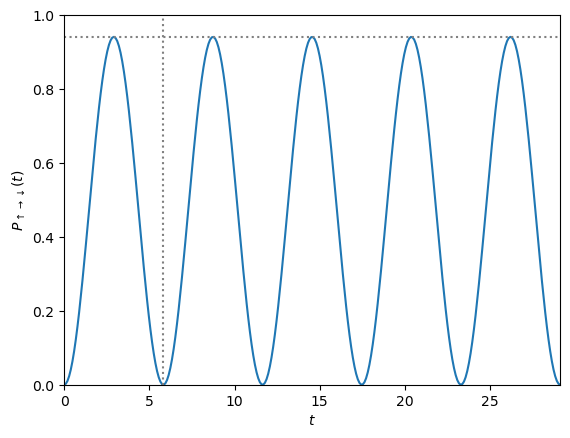

In [14]:
# prob_up2down
fig, ax = plt.subplots()
ax.plot(t, P)
ax.axhline(P_max, ls=':', c='grey')
ax.axvline(T_period, ls=':', c='grey')
ax.set_xlim(t.min(), t.max())
ax.set_ylim(0, 1)
ax.set_xlabel('$t$')
ax.set_ylabel('$P_{ \\uparrow  \\to \\downarrow }(t)$') 
plt.show()

## Gate implementation

As we know, Rabi oscillations in the case of perfect tuning $\omega = \omega_0$ can be used to implement single-qubit gates.

**Question:**
1. What is $\delta$ in that case? What time should we wait for evolution to act like the $NOT$ gate?
2. Using a function creating the Rabi oscillations operator from before, implement the gate. For this, you can use a class [`qiskit.circuit.library.UnitaryGate`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UnitaryGate).

In [15]:
from qiskit.circuit.library import UnitaryGate

omega_1 = np.pi / 3
delta = 0
t_not = np.pi / omega_1

not_gate = UnitaryGate(operator_Rabi_oscillations(delta, omega_1, t_not), label='RabiX')

Now, we instantiate a one-qubit circuit ([`qiskit.circuit.QuantumCircuit`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit)):

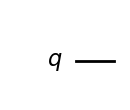

In [16]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(1)
circ.draw('mpl')

The input state is always assumed to be $|0\dots 0\rangle$. Then, we append a gate to the first (and only) wire:

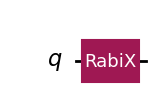

In [17]:
circ.append(not_gate, [0])
circ.draw('mpl')

The circuit was modified in place. Now, we can make measurements by calling [`.measure_all()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#measure_all) method.

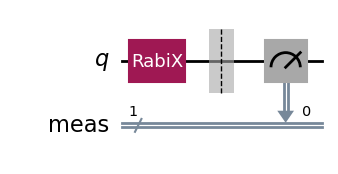

In [18]:
circ.measure_all()
circ.draw('mpl')

It automatically created a classical register &mdash; i.e. a place to store the result &mdash; and added a measurement of the qubit.

*Note:* When you only want to measure only some qubits out of many, you should use [`.measure()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#measure) method instead, but in that case, you have to specify a number of classical bits when instantiating the circuit or add [`ClassicalRegister`](https://docs.quantum.ibm.com/api/qiskit/circuit#classicalregister) manually.

Finally, we simulate the process of measurements. The most basic simulator is  [`qiskit.primitives.StatevectorSampler`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler). It is a perfect simulator, i.e. there is no noise in the measurements.

In [19]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

Then, we launch a job by calling [`.run()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler#run) method, where we specify a list of circuits and `shots`, i.e. a number of times we run a circuit and make a measurement. After this, we call `.result()` to retrieve a list of results, take its first (and only) item and obtain counts of how many times we encountered each bitstring.

In [20]:
n_shots = 1000
job = sampler.run([circ], shots=n_shots)
result = job.result()
counts = result[0].data.meas.get_counts()

[`qiskit.visualization.plot_histogram`](https://docs.quantum.ibm.com/api/qiskit/qiskit.visualization.plot_histogram#qiskitvisualizationplot_histogram) allows us to make a quick visualization of the counts.

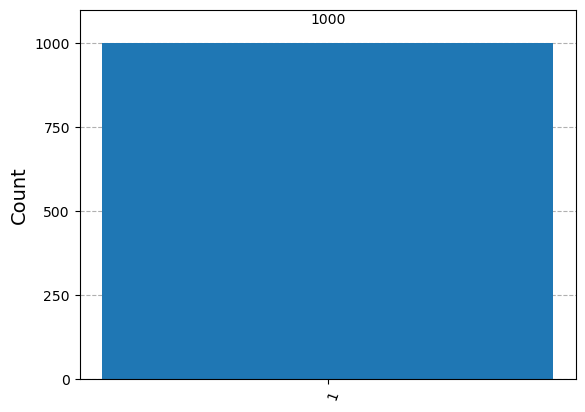

In [21]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

We see that all measurements gave us state $| 1 \rangle$ &mdash; as we would like to have from NOT gate.

Now, let's do the same for input state $|1\rangle$. We can set the qubits in the desired state by either adding suitable gates &mdash; for example, in this case, we could append a true $NOT$ gate by calling [`.x()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#x) method of the circuit. Or, if we want to use a general state vector, we could use [`.prepare_state()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#prepare_state) like below:

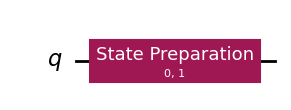

In [22]:
circ = QuantumCircuit(1)
circ.prepare_state([0, 1], 0)
circ.draw('mpl')

**Question:** now, repeat the steps above and observe the measurements after applying the gate to input state $|1\rangle$.

*Note:* You don't have to reinstantiate the simulator.

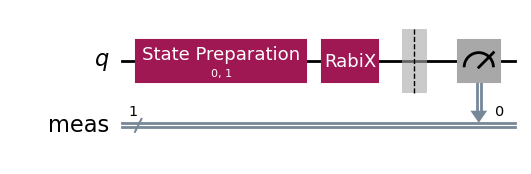

In [23]:
circ.append(not_gate, [0])
circ.measure_all()
circ.draw('mpl')

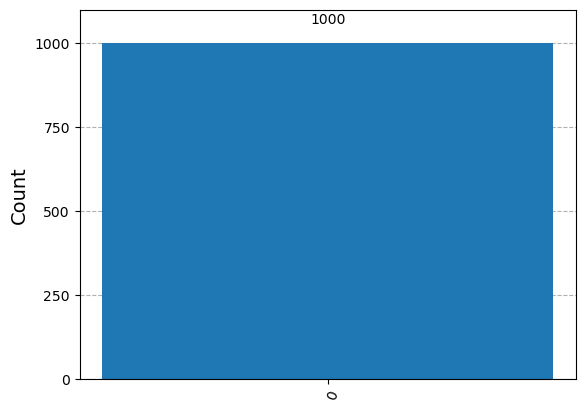

In [24]:
counts = sampler.run([circ], shots=n_shots).result()[0].data.meas.get_counts()
plot_histogram(counts)

Another gate that can be implemented using Rabi oscillations is the Hadamard gate. 

**Question:** Again, repeat the steps from above: find correct $\delta$ and $t$ and implement the gate. Then, make circuits applying your gate to various input states: $|0\rangle$, $|1\rangle$; $\frac{1}{\sqrt{2}}\left(|0\rangle \pm |1\rangle \right)$; $\frac{1}{\sqrt{2}}\left(|0\rangle \pm i |1\rangle \right)$ and perform the measurements.

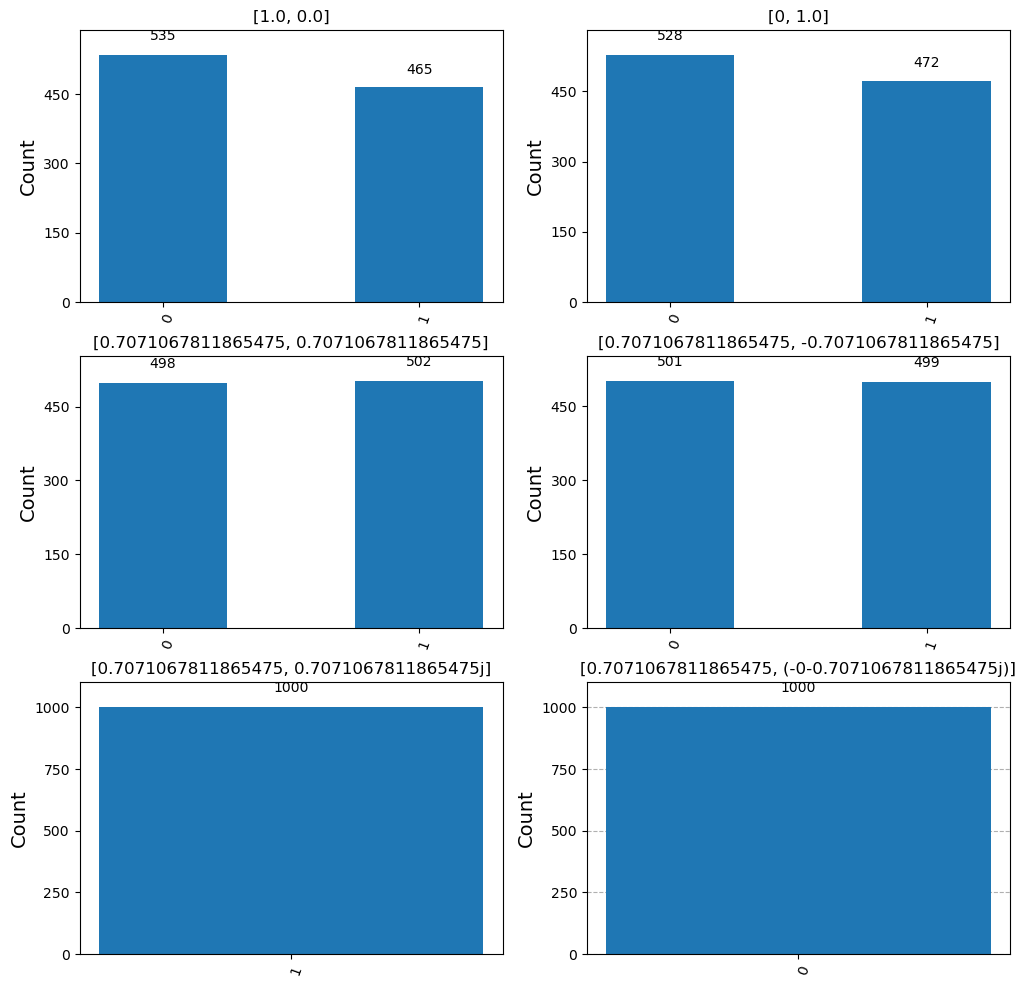

In [24]:
delta = 0
t_h = np.pi / (2 * omega_1)

h_gate = UnitaryGate(operator_Rabi_oscillations(delta, omega_1, t_h), label='RabiH')

init_states = [
    [1., 0.],
    [0, 1.],
    [1/np.sqrt(2), 1/np.sqrt(2)],
    [1/np.sqrt(2), -1/np.sqrt(2)],
    [1/np.sqrt(2), 1j/np.sqrt(2)],
    [1/np.sqrt(2), -1j/np.sqrt(2)]
]

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for i, state in enumerate(init_states):
    ax = axs[i // 2, i % 2]
    
    circ = QuantumCircuit(1)
    circ.prepare_state(state)
    circ.append(h_gate, [0])
    circ.measure_all()
    counts = sampler.run([circ], shots=n_shots).result()[0].data.meas.get_counts()
    plot_histogram(counts, ax=ax)
    ax.set_title(repr(state))